<a href="https://colab.research.google.com/github/Yanaub/3/blob/main/Res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!pip install tensorflow-addons
import glob
data_dir="/content/drive/MyDrive/Почки/train/"

train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s eta 0:00:00
Found 5558 files belonging to 4 classes.
Using 5003 files for training.
Found 5558 files belonging to 4 classes.
Using 1111 files for validation.


In [ ]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


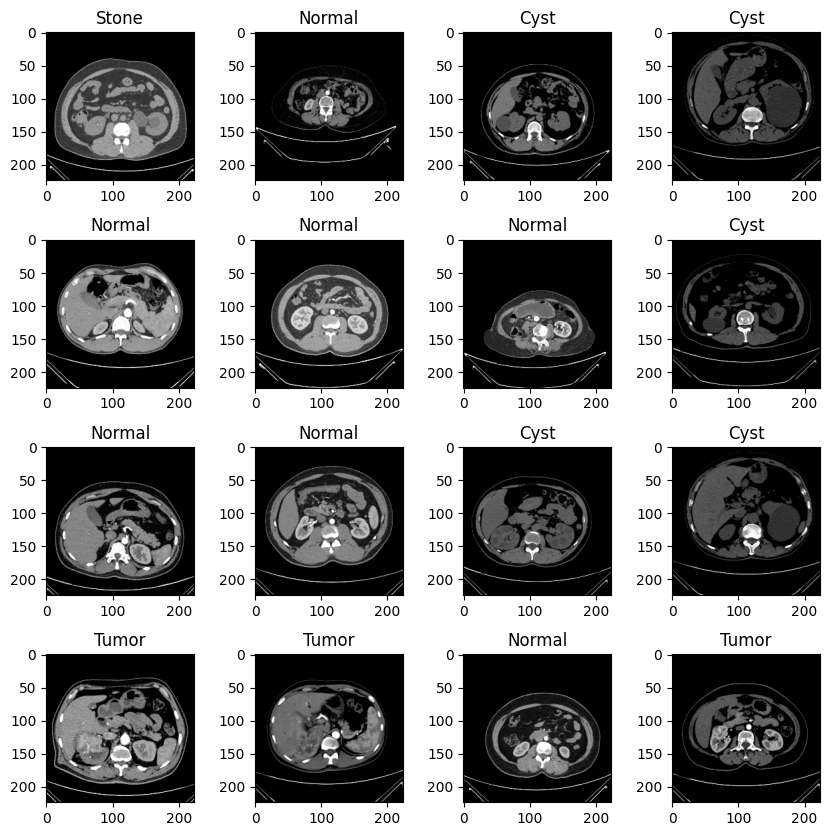

In [ ]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

resnet_model = ResNet50(input_shape=(224,224,3), include_top=False)

for layer in resnet_model.layers:
    layer.trainable = True

x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

resnet_net = Model(inputs=resnet_model.input, outputs=output)

In [ ]:
resnet_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=10
history = resnet_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/10
157/157 [==============================] - 98s 420ms/step - loss: 0.3235 - accuracy: 0.9284 - val_loss: 1.5197 - val_accuracy: 0.1791
Epoch 2/10
157/157 [==============================] - 53s 336ms/step - loss: 0.1051 - accuracy: 0.9896 - val_loss: 27.2217 - val_accuracy: 0.2646
Epoch 3/10
157/157 [==============================] - 52s 332ms/step - loss: 0.0989 - accuracy: 0.9880 - val_loss: 184.6131 - val_accuracy: 0.2646
Epoch 4/10
157/157 [==============================] - 52s 334ms/step - loss: 0.0836 - accuracy: 0.9928 - val_loss: 154.0410 - val_accuracy: 0.2646
Epoch 5/10
157/157 [==============================] - 52s 333ms/step - loss: 0.0657 - accuracy: 0.9942 - val_loss: 4.2834 - val_accuracy: 0.2763
Epoch 6/10
157/157 [==============================] - 53s 336ms/step - loss: 0.0520 - accuracy: 0.9976 - val_loss: 1.8646 - val_accuracy: 0.5617
Epoch 7/10
157/157 [==============================] - 53s 338ms/step - loss: 0.0501 - accuracy: 0.9958 - val_loss: 0.2691 - v

In [ ]:
resnet_net.save("/content/drive/MyDrive/Почки/log/my_model.keras")
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/Почки/log/ResNet_training.csv', index=False)
resnet_net.save('/content/drive/MyDrive/Почки/log/ResNet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Assuming you have a model 'model' and a test dataset 'test_dataset'

# Make predictions using your model
predictions = resnet_net.predict(val)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in val], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

# Save the confusion matrix in pkl format
with open('/content/drive/MyDrive/Почки/log/ResNet_confusion_matrix.pkl', 'wb') as f:

    pickle.dump(cm, f)
    print(cm)

35/35 [==============================] - 4s 90ms/step
[[294   0   0   0]
 [  0 497   0   0]
 [  0   0 121   0]
 [  0   0   0 199]]


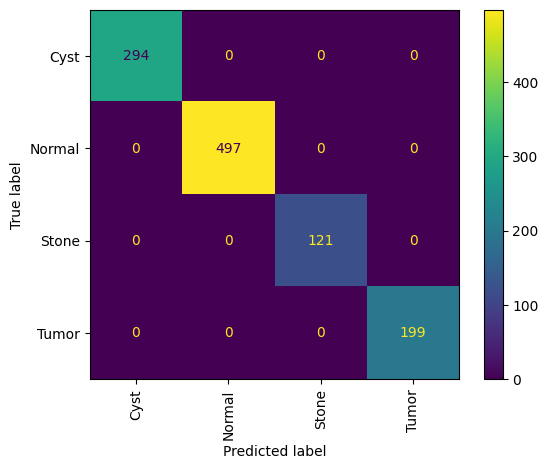

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load the saved confusion matrix
with open('/content/drive/MyDrive/Почки/log/ResNet_confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Define class names (assuming you have them)
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']   # Replace with your actual class names

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

# Show the confusion matrix plot
plt.show()

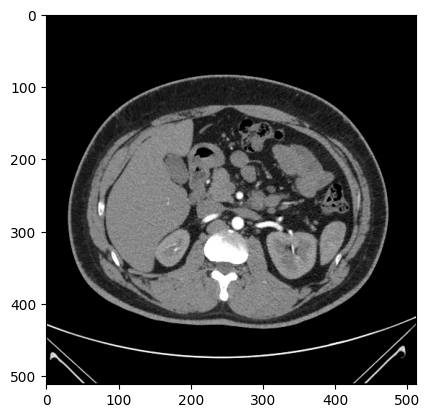

1/1 [==============================] - 0s 46ms/step
[[6.9447765e-07 9.9999738e-01 1.8114121e-06 5.5125767e-08]]


'Normal'

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Почки/test/Normal/Normal- (27).jpg')
#img = cv2.imread('/content/drive/MyDrive/Почки/test/Cyst/Cyst- (140).jpg')
#img = cv2.imread('/content/drive/MyDrive/Почки/test/Stone/Stone- (169).jpg')
#img = cv2.imread('/content/drive/MyDrive/Почки/test/Tumor/Tumor- (30).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = resnet_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(yhat)
label_to_class_name[max_index]

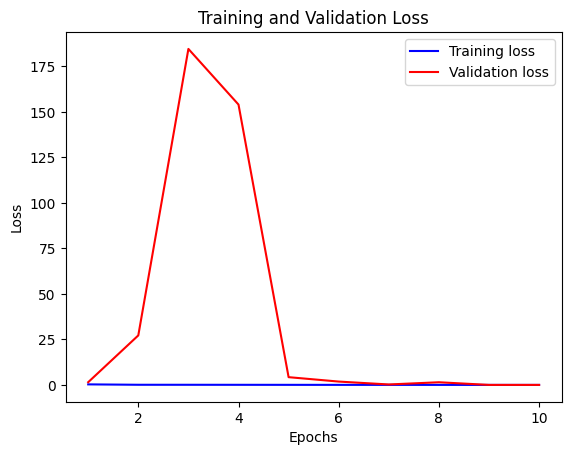

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

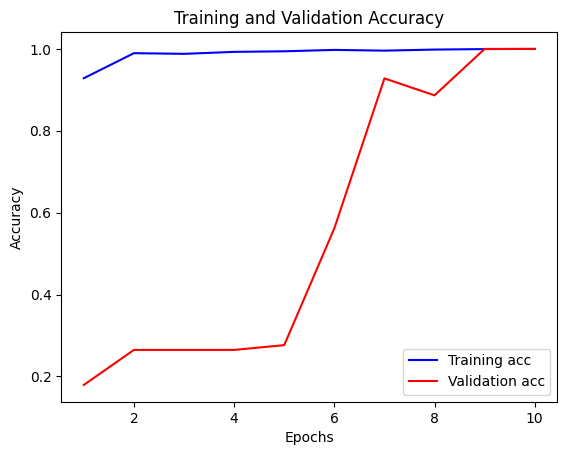

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
data_dir="/content/drive/MyDrive/Почки/test/"

test1=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
test2=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 2160 files belonging to 4 classes.
Using 1944 files for training.
Found 2160 files belonging to 4 classes.
Using 432 files for validation.


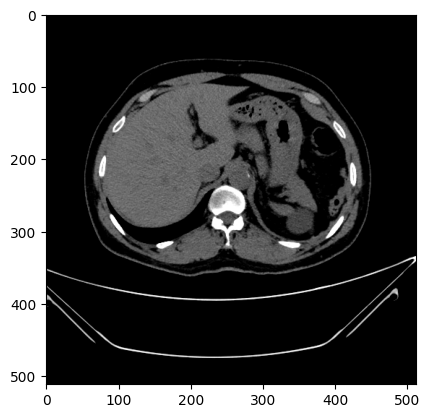

1/1 [==============================] - 1s 927ms/step
[[9.9998474e-01 1.4023593e-05 7.5871941e-07 3.9336476e-07]]


'Cyst'

In [ ]:
model_loaded = keras.models.load_model('/content/drive/MyDrive/Почки/log/ResNet_model.h5')
#img = cv2.imread('/content/drive/MyDrive/Почки/test/Normal/Normal- (94).jpg')
img = cv2.imread('/content/drive/MyDrive/Почки/test/Cyst/Cyst- (77).jpg')
#img = cv2.imread('/content/drive/MyDrive/Почки/test/Stone/Stone- (169).jpg')
#img = cv2.imread('/content/drive/MyDrive/Почки/test/Tumor/Tumor- (30).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = model_loaded.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
print(yhat)
label_to_class_name[max_index]